In [241]:
# Libs
import numpy as np
import matplotlib.pyplot as plt

### Synthetic World

In [271]:
# world parameters
length, width = 500, 3
jump_length = 2

# probabilities of treasures, pirates, obstacles in percent:
rate_treasures, rate_pirates, rate_obstacles = .05, .05, .05

# create grid 
grid = np.zeros((length, width+2*jump_length))
for i in range(jump_length):
    grid[:,i] = grid[:,width+jump_length+i] = -1

# generate treasures, pirates and obstacles using MC sampling.
# the 0 the row is the most likely to have treasures, then the 1 then the 2
mc_samplings = [np.random.rand(length, width), np.random.rand(length, width), np.random.rand(length, width)]
rates = [rate_treasures, rate_pirates, rate_obstacles]
for i in range(length):
    for j in range(width):
        mc_sampls = [0.15*(j+1)*mc_samplings[0][i,j], mc_samplings[1][i,j], mc_samplings[2][i,j]]
        id = np.argmin(mc_sampls)
        if mc_sampls[id] <= rates[id]:
            if id == 0:
                grid[i, j+jump_length] = 1 # treasures
            elif id == 1:
                grid[i, j+jump_length] = 2 # pirates
            elif id == 2:
                grid[i, j+jump_length] = -1

#### plotting World

In [272]:
data_treasures, data_pirates, data_obstacles = [], [], []
for i in range(length):
    for j in range(width):
        v = grid[:, jump_length:-jump_length][i, j] # grid[i, j]
        if v != 0:
            if v == 1:
                data_treasures.append((i, j))
            elif v == 2:
                data_pirates.append((i, j))
            elif v == -1:
                data_obstacles.append((i, j))

Text(0,0.5,'probability  of treasures decreasing with height')

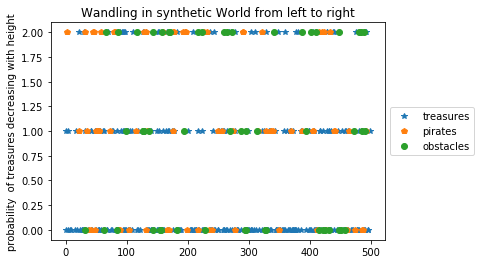

In [360]:
plt.plot(list(map(lambda x: x[0], data_treasures)), list(map(lambda x: x[1], data_treasures)), '*', label='treasures')
plt.plot(list(map(lambda x: x[0], data_pirates)), list(map(lambda x: x[1], data_pirates)), 'p', label='pirates')
plt.plot(list(map(lambda x: x[0], data_obstacles)), list(map(lambda x: x[1], data_obstacles)), 'o', label='obstacles')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Wandling in synthetic World from left to right')
plt.ylabel('probability  of treasures decreasing with height')

### Stationary Bandits

In [274]:
# optimal policy, when possible choose the 0-th rank, 
# if not the 1 then only when both unpossible the 2...
def next_possible_state(coord, grid, w=2):
    #print(coord)
    i, j = coord
    i = i+1
    if i > grid.shape[0]:
        return -1
    else:
        next_states = list(map(lambda x: (i, x), 
                               list(filter(lambda x: (width > x > -1) and (grid[i, x] != -1),
                                           range(j-w, j+w))) ))
        if len(next_states) != 0:
            return next_states
        else:
            return 'No Path Possible'

In [275]:
# Utilities

def action_value_function(coords, grid, reward_treasure=10, cost_pirates=-10):
    """   """
    score = 0.
    for i, j in coords:
        if grid[i,j] == 2:
            score += cost_pirates
        elif grid[i,j] == 1:
            score += reward_treasure
    return score / len(coords)

class Policy:
    """ Policy that prefers the nth rank when possible """
    def __init__(self, rank):
        self.rank = rank
        self.path = []
        self.reward = 0.
    
    def action(self, position, jump_length=jump_length):
        possible_coords = next_possible_state(position,
                                              grid[:, jump_length:-jump_length])
        if self.rank in [c[1] for c in possible_coords]:
            c = list(filter(lambda x: x[1] == self.rank, possible_coords))[0]
            self.path.append(c)
        else:
            ix = np.random.choice(range(len(possible_coords)))
            self.path.append(possible_coords[ix])

        self.reward = action_value_function(self.path, grid[:, jump_length:-jump_length])
        return self.path[-1]

    def action_value(self):
        return self.reward


In [361]:

class PolicyGreedy:
    """ greedy Policy that uses more and more efficient policies """
    def __init__(self, epsilon, policies):
        self.epsilon = epsilon
        self.path = []
        self.reward = 0.
        self.policies = policies

    def action(self, position, jump_length=jump_length):
        possible_coords = next_possible_state(position,
                                              grid[:, jump_length:-jump_length])
        idces = [c[1] for c in possible_coords]
        d_idces_coord = dict([(c[1], c) for c in possible_coords])
        scores = np.array([p.action_value() for p in policies])
        id = np.argmax(scores)
        
        mc = np.random.random()
        if (self.epsilon > mc) or \
           (np.where(scores==max(scores))[0].shape[0] > 1) or \
           (not id in idces):
            id = np.random.choice(idces)
        else:
            id = np.argmax(scores)
        # print(id, ' : ', possible_coords)
        coord = d_idces_coord[id] # possible_coords[id]
        self.path.append(coord)
        self.reward = action_value_function(self.path, grid[:, jump_length:-jump_length])
        return self.path[-1]


In [370]:
"""
    Run policies and greedy strategies
"""

policy_0 = Policy(0)
policy_1 = Policy(1)
policy_2 = Policy(2)

policies = [policy_0, policy_1, policy_2]
epsilon = 0.1
policy_greedy_0 = PolicyGreedy(epsilon/2, policies)
policy_greedy_1 = PolicyGreedy(epsilon, policies)
policy_greedy_2 = PolicyGreedy(epsilon*2, policies)

policy_0.action((-1, 0))
policy_1.action((-1, 1))
policy_2.action((-1, 2))
move_0 = policy_greedy_0.action((-1, 1))
move_1 = policy_greedy_1.action((-1, 1))
move_2 = policy_greedy_2.action((-1, 1))

for i in range(length-1):
    policy_0.action((i, 0))
    policy_1.action((i, 1))
    policy_2.action((i, 2))
    move_0 = policy_greedy_0.action(move_0)
    move_1 = policy_greedy_1.action(move_1)
    move_2 = policy_greedy_2.action(move_2)

In [371]:
# scores first, second and third lines
policy_0.reward, policy_1.reward, policy_2.reward

(2.86, 1.04, 0.34)

In [372]:
# scores greedy epsilon resp.: 0.05, 0.1, 0.2
policy_greedy_0.reward, policy_greedy_1.reward, policy_greedy_2.reward

(2.8, 2.84, 2.62)

In [373]:
rew_0, rew_1, rew_2 = [], [], []
rew_e0, rew_e1, rew_e2 = [], [], []
for i in range(1,length):
    rew_0.append(action_value_function(policy_0.path[:i], grid[:, jump_length:-jump_length]))
    rew_1.append(action_value_function(policy_1.path[:i], grid[:, jump_length:-jump_length]))
    rew_2.append(action_value_function(policy_2.path[:i], grid[:, jump_length:-jump_length]))
    
    rew_e0.append(action_value_function(policy_greedy_0.path[:i], grid[:, jump_length:-jump_length]))
    rew_e1.append(action_value_function(policy_greedy_1.path[:i], grid[:, jump_length:-jump_length]))
    rew_e2.append(action_value_function(policy_greedy_2.path[:i], grid[:, jump_length:-jump_length]))

Text(0.5,0,'nb of step')

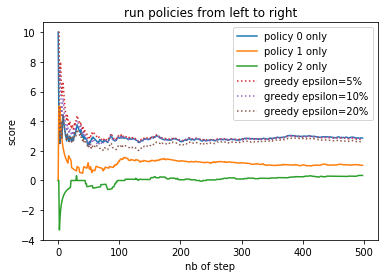

In [374]:
plt.plot(rew_0, label='policy 0 only')
plt.plot(rew_1, label='policy 1 only')
plt.plot(rew_2, label='policy 2 only')

plt.plot(rew_e0, label='greedy epsilon=5%', linestyle=':')
plt.plot(rew_e1, label='greedy epsilon=10%', linestyle=':')
plt.plot(rew_e2, label='greedy epsilon=20%', linestyle=':')

plt.legend(loc='upper right')
plt.title('run policies from left to right')
plt.ylabel('score')
plt.xlabel('nb of step')